In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [2]:
(training_set,validation_set),dataset_info = tfds.load('tf_flowers',
                                                      split=['train[:70%]','train[70%:]'],
                                                      with_info=True,
                                                      as_supervised=True)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [3]:
num_classes = dataset_info.features['label'].num_classes

In [4]:
num_classes

5

In [5]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1

In [6]:
num_training_examples

2569

In [7]:
num_validation_examples

1101

In [8]:
print("Total number of classes: {}".format(num_classes))
print("Total numbers of Training Images: {}".format(num_training_examples))
print("Total numbers of validation Images: {}\n".format(num_validation_examples))

Total number of classes: 5
Total numbers of Training Images: 2569
Total numbers of validation Images: 1101



In [9]:
for i,examples in enumerate(training_set.take(5)):
    print("Image {} shape: {} label: {}".format(i+1,examples[0].shape,examples[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [10]:
IMG_RES = 224
def format_image(image,label):
    image = tf.image.resize(image,(IMG_RES,IMG_RES))/255.0
    return image, label

In [11]:
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [12]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [13]:
feature_extractor = hub.KerasLayer(URL,input_shape=(IMG_RES,IMG_RES,3))

In [14]:
feature_extractor.trainable = False

In [15]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(num_classes)
])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [17]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [18]:
Epochs = 6
history = model.fit(train_batches,epochs=Epochs,
                   validation_data=validation_batches)

Epoch 1/6
81/81 [==============================] - 182s 2s/step - loss: 0.8321 - accuracy: 0.6937 - val_loss: 0.4803 - val_accuracy: 0.8356
Epoch 2/6
81/81 [==============================] - 141s 2s/step - loss: 0.3985 - accuracy: 0.8649 - val_loss: 0.3565 - val_accuracy: 0.8865
Epoch 3/6
81/81 [==============================] - 127s 2s/step - loss: 0.3143 - accuracy: 0.8953 - val_loss: 0.3235 - val_accuracy: 0.8955
Epoch 4/6
81/81 [==============================] - 142s 2s/step - loss: 0.2554 - accuracy: 0.9186 - val_loss: 0.3114 - val_accuracy: 0.8983
Epoch 5/6
81/81 [==============================] - 131s 2s/step - loss: 0.2240 - accuracy: 0.9311 - val_loss: 0.2885 - val_accuracy: 0.9028
Epoch 6/6
81/81 [==============================] - 131s 2s/step - loss: 0.1971 - accuracy: 0.9404 - val_loss: 0.2798 - val_accuracy: 0.9028


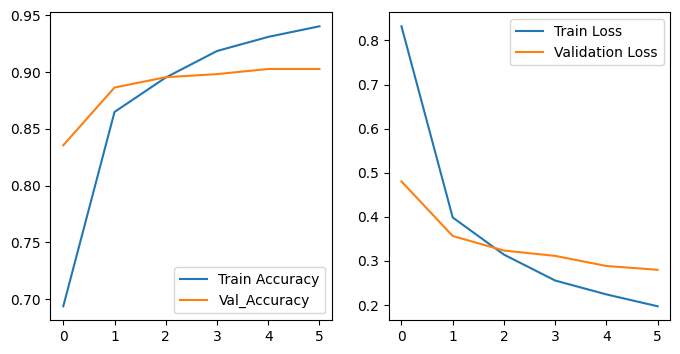

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(Epochs)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(epochs_range,acc,label='Train Accuracy')
plt.plot(epochs_range,val_acc,label='Val_Accuracy')
plt.legend(loc=0)
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label='Train Loss')
plt.plot(epochs_range,val_loss,label='Validation Loss')
plt.legend(loc=0)
plt.show()

In [20]:
class_names = np.array(dataset_info.features['label'].names)

In [21]:
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [22]:
image_batch,label_batch = next(iter(train_batches))

In [23]:
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [24]:
predicted_batch = model.predict(image_batch)

1/1 [==============================] - 2s 2s/step


In [25]:
predicted_batch = tf.squeeze(predicted_batch).numpy()

In [26]:
predicted_batch

array([[-1.607249  ,  0.10127229, -4.677503  ,  3.058142  , -4.935818  ],
       [-0.89666945, -0.419947  , -3.4716618 , -0.25006706, -7.0889297 ],
       [-2.0290945 ,  2.881301  , -2.515319  , -1.1763653 , -2.8856933 ],
       [-1.3187604 ,  1.0406609 , -4.1639595 ,  2.9309287 , -3.9308722 ],
       [-3.7117474 , -2.9513755 , -2.4892495 ,  4.1710987 , -4.9869127 ],
       [-6.969309  , -1.5022845 , -2.0423906 , -1.3725188 , -0.03932223],
       [-6.5172706 , -5.296147  ,  3.272321  , -5.7549706 ,  0.8179417 ],
       [-7.2539563 , -5.64296   ,  2.9861062 , -3.80198   ,  2.632407  ],
       [ 0.02279392, -0.77364767, -4.4406667 , -4.484403  , -7.4105215 ],
       [ 4.3019357 , -2.9155605 , -4.474938  , -3.5685418 , -4.5229325 ],
       [-2.3454678 , -5.672445  ,  1.2639633 , -3.8213634 , -1.9410087 ],
       [-8.709754  , -6.691118  ,  5.884263  , -5.313396  ,  0.45160377],
       [-7.2257156 , -6.3463945 ,  3.769766  , -4.865551  , -1.8808591 ],
       [ 5.4929967 , -3.4811103 , -6.0

In [27]:
predicted_ids = np.argmax(predicted_batch,axis=-1)

In [28]:
predicted_ids

array([3, 3, 1, 3, 3, 4, 2, 2, 0, 0, 2, 2, 2, 0, 4, 4, 1, 1, 4, 3, 3, 4,
       0, 0, 3, 3, 0, 2, 2, 0, 1, 0])

In [29]:
predicted_class_names = class_names[predicted_ids]

In [30]:
predicted_class_names

array(['sunflowers', 'sunflowers', 'daisy', 'sunflowers', 'sunflowers',
       'roses', 'tulips', 'tulips', 'dandelion', 'dandelion', 'tulips',
       'tulips', 'tulips', 'dandelion', 'roses', 'roses', 'daisy',
       'daisy', 'roses', 'sunflowers', 'sunflowers', 'roses', 'dandelion',
       'dandelion', 'sunflowers', 'sunflowers', 'dandelion', 'tulips',
       'tulips', 'dandelion', 'daisy', 'dandelion'], dtype='<U10')

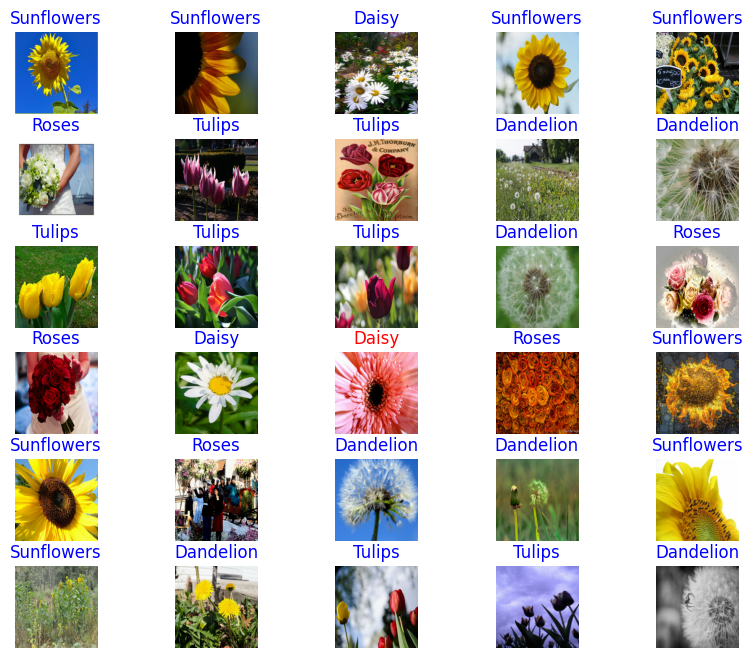

In [31]:
plt.figure(figsize=(10,8))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace=0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n]==label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(),color=color)
    plt.axis('off')